In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import graphviz

In [2]:
flights_df = pd.read_csv('complete_flight_info_and weather_data.csv')

# convert flight date to date object
flights_df = flights_df.drop(['date', 'date.1','CRS_DEP_TIME','ORIGIN','DEST'], axis=1)

flights_df = flights_df.dropna()
 
flights_df['FL_DATE'] = pd.to_datetime(flights_df['FL_DATE'])
del flights_df['DOT_CODE']
# Remove columns starting with 'origin' and 'dest'
columns_to_remove = [col for col in flights_df.columns if col.startswith('ORIGIN') or col.startswith('DEST')]
flights_df = flights_df.drop(columns=columns_to_remove)

# converts string TRUE/FALSE to boolean
flights_df.replace({'TRUE': True, 'FALSE': False}, inplace=True)

# convert FL_Date to year, month, day
flights_df['FL_YEAR'] = pd.to_datetime(flights_df['FL_DATE']).dt.year
flights_df['FL_MONTH'] = pd.to_datetime(flights_df['FL_DATE']).dt.month
flights_df['FL_DAY'] = pd.to_datetime(flights_df['FL_DATE']).dt.day

# drop original date time
flights_df.drop(columns=['FL_DATE'], inplace=True)

X = flights_df.loc[:, flights_df.columns != 'ARR_DELAY']
y = flights_df['ARR_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 156, shuffle=True)

In [3]:
model_rf = RandomForestRegressor (n_estimators=100, random_state=156, max_features=30)

model_rf.fit(X_train, y_train)
preds_test = model_rf.predict(X_test)

print(mean_squared_error(y_test, preds_test), r2_score(y_test, preds_test))

91.00437812925169 0.9923949564139596


In [4]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestRegressor(random_state=156)

params = {
    'max_depth': np.arange(1,30,5),
    'n_estimators': np.arange(1,30,5)
}

grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=156), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26]),
                         'n_estimators': array([ 1,  6, 11, 16, 21, 26])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [5]:
# Get the best estimator and show parameters
grid_search.best_params_

{'max_depth': 11, 'n_estimators': 26}

In [6]:
# Evaluate the tuned model

clf_best = grid_search.best_estimator_
y_test_pred = clf_best.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Calculate MAPE
abs_errors = np.abs(y_test - y_test_pred)
percentage_errors = (abs_errors / y_test) * 100
mape = np.mean(percentage_errors)

print('Hyperparameter tuning of random forest yields MSE and R-squared:', mean_squared_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))
print('MSE:', mse)
print('R-squared:', r2)
print('MAPE:', mape)

Hyperparameter tuning of random forest yields MSE and R-squared: 77.45710801682188 0.9935270731515804
MSE: 77.45710801682188
R-squared: 0.9935270731515804
MAPE: 15.280366510113314


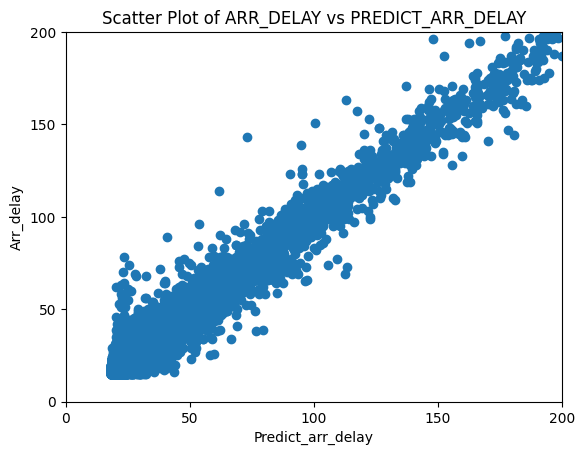

In [7]:
# Create the scatter plot
plt.scatter( y_test_pred, y_test)

plt.ylabel('ARR_DELAY'.capitalize())
plt.yticks([0, 50, 100, 150, 200], ['0', '50', '100', '150', '200'])

plt.xlabel('PREDICT_ARR_DELAY'.capitalize())
plt.xticks([0, 50, 100, 150, 200], ['0', '50', '100', '150', '200'])

plt.xlim([0, 200])
plt.ylim([0, 200])

plt.title('Scatter Plot of ARR_DELAY vs PREDICT_ARR_DELAY')

plt.show()